In [2]:
import re
import numpy as np
import pandas as pd
import openpyxl

import os
import math
from bs4 import BeautifulSoup
from lxml import html
import requests
import warnings

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import io
import json

import plotly.graph_objects as go
import plotly.express as px
import plotly as py

pd.set_option('display.max_rows',999)
pd.set_option('display.min_rows',4)
pd.set_option('display.float_format', '{:,.2f}'.format)

warnings.filterwarnings("ignore")

20 colores

In [3]:
cl = [e for e in sns.color_palette('rocket',20)]
cl2 = [(int(t[0]*255), int(t[1]*255) , int(t[2]*255)) for t in cl]
colors = ['#%02x%02x%02x' % e for e in cl2]

idx

In [4]:
idx = pd.IndexSlice

Bases

In [5]:
dbox = r'c:/Users/Franco/Dropbox/files/clean/'
files = os.listdir(dbox)

In [6]:
sectores = pd.read_excel(dbox+'sectores.xlsx',index_col=[0,1])
laboral = pd.read_excel(dbox+'laboralv1.xlsx',index_col=[0,1])
acceso = pd.read_excel(dbox+'accesom_2.xlsx',index_col=[0,1])
accesom = pd.read_excel(dbox+'horas_msII.xlsx',index_col=[0,1]) 
cw = pd.read_excel(dbox+'cwpops.xlsx',index_col=[0,1])
latlongs = pd.read_excel(dbox+'latlongs.xlsx',index_col=[0,1])
msa = pd.read_excel(dbox+'metro_areas.xlsx',index_col=[0,1])
mlab = pd.read_excel(dbox+'mlabi.xlsx',index_col=[0,1])
prope_com = pd.read_excel(dbox+'prope_comercial.xlsx',index_col=[0,1])
prope_vi = pd.read_csv(dbox+'prope_vivienda.csv',index_col=[0,1])
hom = pd.read_excel(dbox+'homicidios.xlsx',index_col=[0,1])
es2 = pd.read_excel(dbox+'dbiz-es/es2.xlsx',index_col=[0,1])
es = pd.read_excel(dbox+'dbiz-es/es.xlsx',index_col=[0,1])
db = pd.read_excel(dbox+'dbiz-es/dbiz.xlsx',index_col=[0,1])

Ciudades de referencia

In [63]:
#with open('ref.json') as f:
#    d = json.load(f)
#
#city = (d['city']['Country'],d['city']['City'])
#
#refs = []
#
#(d['ref']['1']['Country'],d['ref']['1']['City'])
#
#for k in d['ref'].keys():
#    refs = refs + [(d['ref'][k]['Country'],d['ref'][k]['City'])]
#
#refs1 = [e[1] for e in refs]

In [64]:
city = ('Mexico','Puebla-Tlaxcala')
ref = [city[1]] + ['Tlaxcala-Apizaco','La Laguna','Toluca','Guadalajara','Gran Rosario','Natal','Bucaramanga']
ref_prom = ref + ['Promedio {}'.format(city[0]),'Promedio Latam']

Tabla 1

In [18]:
if (city in cw.index)&(city in laboral.index)&(city in sectores.index):

    comp = cw.loc[idx[:,ref],'pops'].to_frame().join(laboral.loc[:,['Salario Horario (PPP 2011)','Tasa de Desempleo Total','% población con secundario completo Total']]).join(acceso.loc[:,['cutoff_0','cutoff_9']]).join(sectores.loc[:,['Ratio Agro','Ratio Baja Tec','Ratio Resto Ind']])
    comp = comp.rename(columns={'pops':'Población estimada (millones)','cutoff_0':'Masa Salarial como proporción del país','cutoff_9':'Proporción de la masa salarial del país a la que se accede en < 9 hs'})
    #BeautifulSoup(comp.sort_values(['Country','Salario Horario (PPP 2011)']).to_html(), 'html.parser'))
    comp.sort_values(['Country','Salario Horario (PPP 2011)']).to_html(os.getcwd()+r'/informe/images/tabla1.html')

Gráfico de Salarios y poblaciones

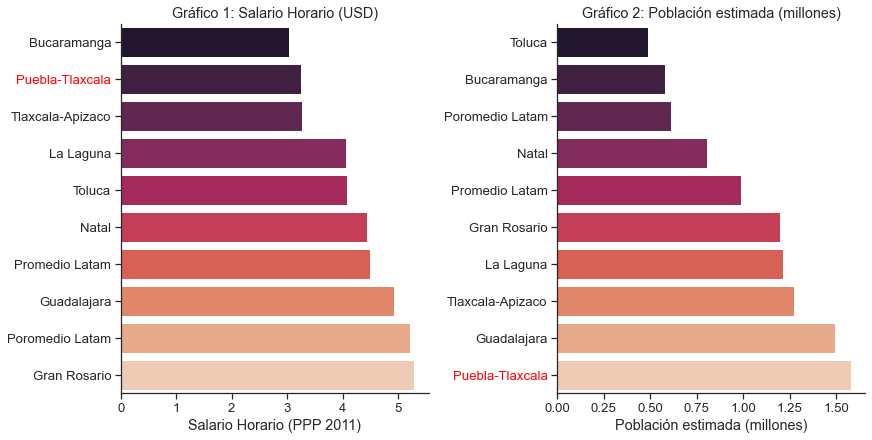

In [111]:
if (city in cw.index)&(city in laboral.index):
    
    #Tabla

    plot1 = comp.iloc[:,:2].droplevel(0)

    proms = pd.concat([cw.loc[:,['pops']].mean().to_frame().T.append(cw.loc[city[0],['pops']].mean().to_frame().T),pd.Series(laboral.iloc[:,0].mean()).append(pd.Series(laboral.loc[city[0],'Salario Horario (PPP 2011)'].mean())).to_frame()],axis=1).rename(columns={'pops':'Población estimada (millones)',0:'Salario Horario (PPP 2011)'})
    proms['City'] = ['Poromedio Latam', ref_prom[-1]]
    proms = proms.set_index('City')

    plot1 = plot1.append(proms)

    #Plot

    contgraf = 0

    f, axes = plt.subplots(1, 2,figsize=(12,6) ,constrained_layout=True)

    sns.barplot(x='Salario Horario (PPP 2011)', y=plot1.sort_values('Salario Horario (PPP 2011)').index, data=plot1.sort_values('Salario Horario (PPP 2011)'),palette='rocket' , orient='h' , ax=axes[0])
    sns.barplot(x='Población estimada (millones)', y=plot1.sort_values('Población estimada (millones)').index, data=plot1.sort_values('Población estimada (millones)'),palette='rocket' , orient='h'  ,ax=axes[1])

    contgraf = contgraf + 1
    axes[0].set_title('Gráfico {}: Salario Horario (USD)'.format(contgraf))
    contgraf = contgraf + 1
    axes[1].set_title('Gráfico {}: Población estimada (millones)'.format(contgraf))

    sns.set(font_scale=1.2)
    sns.set_style("ticks")
    sns.despine()

    plt.ticklabel_format(style='plain', axis='x')

    a = axes[0].get_yticklabels()
    a[[a[e].get_text() for e in range(len(a))].index(city[1])].set_color('red')
    b = axes[1].get_yticklabels()
    b[[b[e].get_text() for e in range(len(b))].index(city[1])].set_color('red')

    axes[0].set_ylabel('')    
    axes[1].set_ylabel('')

    plt.savefig("informe/images/wyp.png",bbox_inches='tight')

Scatter

In [112]:
if city in sectores.index:

    #Tabla
    wage_comp = sectores.loc[idx[city[0],:],['Salario Observado','Salario Estimado','Principal Sector']]
    wage_comp = wage_comp.reset_index()

    def wc(x):
        if x == 'Agro':
            a = colors[1]
        elif x == 'Baja Tec':
            a = colors[8]
        else:
            a = colors[15]
        return a

    wage_comp['color'] = wage_comp['Principal Sector'].apply(lambda x: wc(x))

    #Plot

    fig = px.scatter(wage_comp[wage_comp['City']!=city[1]], x="Salario Estimado", y="Salario Observado", color="Principal Sector",
                     hover_data=["City","Salario Observado","Salario Estimado","Principal Sector"],
                     template='simple_white',
                     color_discrete_sequence=[colors[1],colors[8],colors[15]],
                     #color="color",
                     width=750,
                     height=500
                    )

    #Guardo los valores de la ciudad principal en una lista para el "hover"
    hov = wage_comp.set_index(['Country','City']).loc[city].tolist()

    #Gráfico

    contgraf = contgraf + 1

    fig.add_trace(go.Scatter( 
                    mode='markers', 
                    x=wage_comp[wage_comp['City']==city[1]]['Salario Estimado'], 
                    y=wage_comp[wage_comp['City']==city[1]]['Salario Observado'],
                    marker=dict( color=colors[15], size=12, line=dict(color='red', width=2)),
                    showlegend=False,
                    text='City: {0}<br />Salario Observado: {1}<br />Salario Estimado: {2}<br />Principal Sector: {3}'.format(city[1], hov[0], hov[1], hov[2]),
                    hoverinfo='text'
                            )
                 )

    fig.update_traces(marker=dict(size=12),
                      selector=dict(mode='markers')
                     )

    #Rangos de ejes
    x_range = (round(wage_comp['Salario Estimado'].min()),math.ceil(wage_comp['Salario Estimado'].max()))
    y_range = (round(wage_comp['Salario Observado'].min()),math.ceil(wage_comp['Salario Observado'].max()))

    fig.update_layout(xaxis_range=[x_range[0] - 0.25,x_range[1] + 0.25],
                      yaxis_range=[y_range[0] - 0.25,y_range[1] + 0.25],
                      title='Gráfico {}: Salario Observado vs Salario Esperado y especialización relativa'.format(contgraf)
                     )

    # add a "target" line
    fig.add_shape(
        type="line", line_color=colors[9], line_width=3, opacity=1, line_dash="dot",
        x0=3, x1=12, xref="x", y0=3, y1=12, yref="y")

    fig.write_html(file="informe/images/estimado_vs_observado.html",full_html=False,include_plotlyjs='cdn')

Sectores

In [117]:
if city in sectores.index:

    #Tabla
    w = sectores.loc[idx[:,city[1]],['share_emp_s1', 'share_emp_s2', 'share_emp_s3', 'share_emp_s4',
           'share_emp_s5', 'share_emp_s6', 'share_emp_s7', 'share_emp_s8',
           'share_emp_s9', 'share_emp_s10','Agro', 'Baja Tec', 'Resto Ind',
           'Construcción', 'Comercio', 'Infraestructura', 'Bancos', 'Adm publi',
           'Educ y Salud', 'Serv doméstic']].stack().to_frame().reset_index().rename(columns={'level_2':'Actividad',0:'Proporción'})

    w['Grupo'] = ['Empleo']*10 + ['Masa Salarial']*10
    w = w.drop(columns=['Country','City'])
    w = w.replace({'Actividad':dict(zip(w['Actividad'][:10],w['Actividad'][10:]))})

    #Plot
    contgraf = contgraf + 1
    fig, ax = plt.subplots(figsize=(16,10))
    g = sns.barplot(x='Actividad', y='Proporción', hue='Grupo', data=w , palette='rocket' , linewidth=1)

    g.set_title('Gráfico {}: Empleo y Masa Salarial por sector'.format(contgraf))
    g.set_xticklabels(w['Actividad'].unique().tolist() , rotation=25 , ha='right')

    sns.set(font_scale=1.2)
    sns.set_style("ticks")
    sns.despine()
    plt.tight_layout()

    plt.savefig("informe/images/wm_sectores.png",bbox_inches='tight')

Distribución de Actividades

In [57]:
if city in laboral.index:

    #Tabla
    dist = laboral[['Distribución de ocupados según relación laboral Asalariado  (total)',
     'Distribución de ocupados según relación laboral Asalariado (público)',
     'Distribución de ocupados según relación laboral Asalariado (privado)',
     'Distribución de ocupados según relación laboral Patrón o Cuentapropista',
     'Distribución de ocupados según relación laboral Sin salario']]

    mean = dist.mean().to_frame().T
    [mean['Country'],mean['City']] = ['Promedio Latam','Promedio Latam']
    mean = mean.set_index(['Country','City'])

    dist_plot = dist.append(mean).loc[idx[:,ref_prom],:].droplevel(0).sort_values(
        'Distribución de ocupados según relación laboral Asalariado  (total)').drop(
        columns='Distribución de ocupados según relación laboral Asalariado  (total)').rename(
        columns=dict(zip(dist.columns[1:].tolist(),['Asalariado (público)','Asalariado (privado)','Patrón o Cuentapropista','Sin salario'])))

    #Plot
    contgraf = contgraf + 1
    fig, ax = plt.subplots(1, 1,figsize=(12,6))

    sns.set_palette('rocket')
    dist_plot.plot(kind='bar', stacked=True , ax=ax , color=sns.color_palette() , width=0.9 , linewidth=0.001)
    ax.set_title('Gráfico {}: Distribución de empleo (porcentajes)'.format(contgraf))

    fig.autofmt_xdate()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    a = ax.get_xticklabels()
    a[[a[e].get_text() for e in range(len(a))].index(city[1])].set_color('red')

    ax.set_xlabel('')
    plt.tight_layout()

    plt.savefig("informe/images/empleo_dist.png",bbox_inches='tight')

### Con Ext

Velocidad de Internet

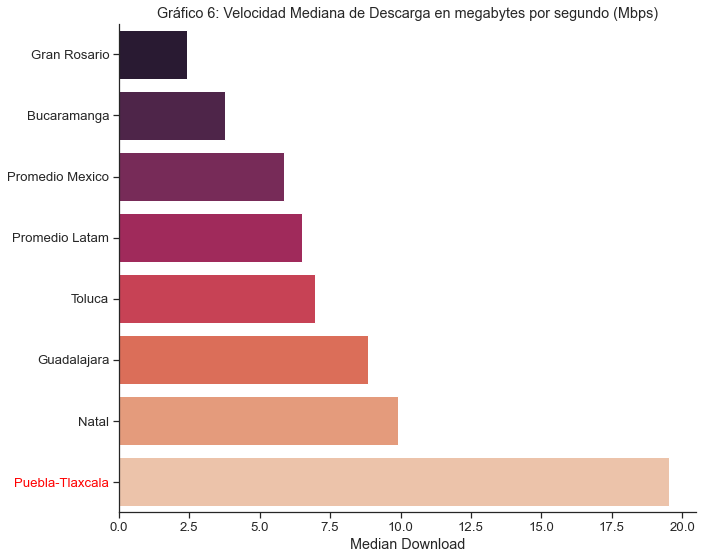

In [253]:
if city in mlab.index:

    #Tabla
    mlab_medias = mlab.mean().to_frame().T.append(mlab.loc[city[0]].mean().to_frame().T)
    mlab_medias['City'] = ['Promedio Latam','Promedio {}'.format(city[0])]
    mlab_medias['Country'] = ['Promedio Latam','Promedio {}'.format(city[0])]
    mlab_medias = mlab_medias.set_index(['Country','City'])
    mlab_plot = mlab.drop(columns='City Original').append(mlab_medias).loc[idx[:,ref_prom],'Median Download'].to_frame().droplevel(0)

    #Plot
    contgraf = contgraf + 1
    fig, ax = plt.subplots(figsize=(10,8))

    sns.barplot(x='Median Download', y=mlab_plot.sort_values('Median Download').index, data=mlab_plot.sort_values('Median Download') , palette='rocket' , orient='h' )

    ax.set_title('Gráfico {}: Velocidad Mediana de Descarga en megabytes por segundo (Mbps)'.format(contgraf))
    sns.set(font_scale=1.2)
    sns.set_style("ticks")
    sns.despine()
    a = ax.get_yticklabels()
    a[[a[e].get_text() for e in range(len(a))].index(city[1])].set_color('red')
    ax.set_ylabel('')    
    plt.tight_layout()

    plt.savefig("informe/images/descarga.png",bbox_inches='tight')

Acceso a mercados

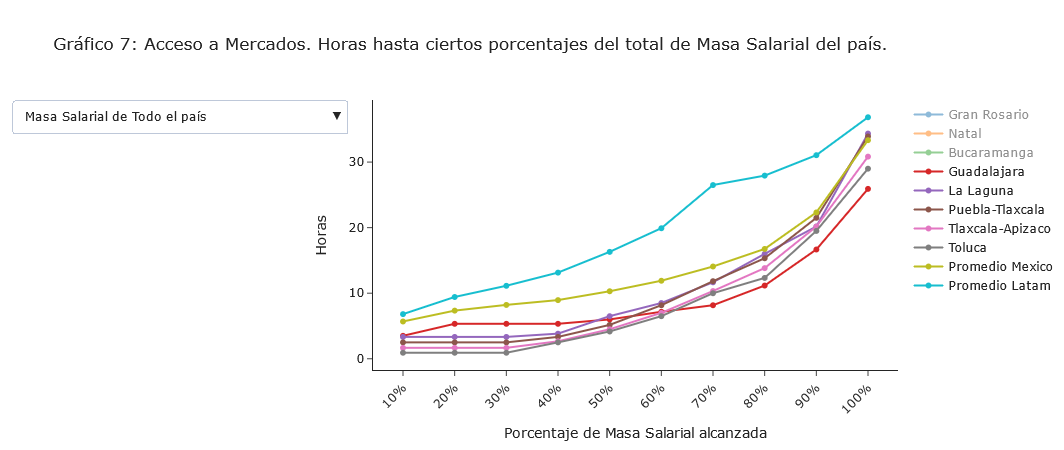

In [281]:
if city in accesom.index:

    #Tablas
    medias = accesom.loc[city[0]].mean().to_frame().T.append(accesom.mean().to_frame().T)
    medias['City'] = ['Promedio {}'.format(city[0]),'Promedio Latam']
    medias['Country'] = ['Promedio {}'.format(city[0]),'Promedio Latam']
    medias = medias.set_index(['Country','City'])

    acceso_plot = accesom.append(medias).loc[idx[:,ref_prom],:]
    plot = acceso_plot.drop(columns=['Población (millones)','Salario Horario (PPP 2011)','Nearest City','Masa Salarial','Masa Salarial (% Total País)','Masa Salarial (Total País)'])


    df1 = plot.loc[:,['Horas al {}% de MS'.format(e) for e in [10,20,30,40,50,60,70,80,90,100]]]
    df2 = plot.loc[:,['Horas al {}% de MS (Salarios mayores)'.format(e) for e in [10,20,30,40,50,60,70,80,90,100]]]

    mydict1 = dict(zip(['Horas al {}% de MS'.format(e) for e in [10,20,30,40,50,60,70,80,90,100]],['10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']))
    mydict2 = dict(zip(['Horas al {}% de MS (Salarios mayores)'.format(e) for e in [10,20,30,40,50,60,70,80,90,100]],['10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']))

    df1 = df1.rename(columns=mydict1).stack().to_frame().reset_index().rename(columns={'level_2':'% de MS',0:'Horas'})
    df2 = df2.rename(columns=mydict2).stack().to_frame().reset_index().rename(columns={'level_2':'% de MS',0:'Horas'})

    #Plot

    contgraf = contgraf + 1

    fig1 = go.Figure()

    for e in df1.City.unique():
        df = df1[df1['City']==e]
        if 'Promedio' not in e:
            if df['Country'].unique() != city[0]:
                fig1.add_trace(go.Scatter(x=df['% de MS'], y=df['Horas'], name=e , visible='legendonly'))    
            else:
                fig1.add_trace(go.Scatter(x=df['% de MS'], y=df['Horas'], name=e))
        else:
            fig1.add_trace(go.Scatter(x=df['% de MS'], y=df['Horas'], name=e))

    fig2 = go.Figure()

    for e in df2.City.unique():
        df = df2[df2['City']==e]
        if 'Promedio' not in e:
            if df['Country'].unique() != city[0]:
                fig2.add_trace(go.Scatter(x=df['% de MS'], y=df['Horas'], name=e , visible='legendonly'))    
            else:
                fig2.add_trace(go.Scatter(x=df['% de MS'], y=df['Horas'], name=e))
        else:
            fig2.add_trace(go.Scatter(x=df['% de MS'], y=df['Horas'], name=e))

    fig = go.Figure()

    for e in df1.City.unique():
        df = df1[df1['City']==e]
        if 'Promedio' not in e:
            if df['Country'].unique() != city[0]:
                fig.add_trace(go.Scatter(x=df['% de MS'], y=df['Horas'], name=e , visible='legendonly'))    
            else:
                fig.add_trace(go.Scatter(x=df['% de MS'], y=df['Horas'], name=e))
        else:
            fig.add_trace(go.Scatter(x=df['% de MS'], y=df['Horas'], name=e))

    updatemenus = [
        {
            'buttons': [
                {
                    'method': 'update',
                    'label': 'Masa Salarial de Todo el país',
                    'args': [
                        {'y': [dat.y for dat in fig1.data],
                         'x': [dat.x for dat in fig1.data],
                         'visible':[dat.visible for dat in fig1.data]

                        },  
                    ]
                },
                {
                    'method': 'update',
                    'label': 'Masa Salarial sólo de Ciudades con salarios mayores',
                    'args': [
                        {'y': [dat.y for dat in fig2.data],
                         'x':[dat.x for dat in fig2.data],
                         'visible':[dat.visible for dat in fig2.data]

                        },
                    ]
                }

            ],
            'direction': 'down',
            'showactive': True,
        }
    ]        

    fig = fig.update_layout(template="simple_white" , updatemenus=updatemenus , title_text="Gráfico {}: Acceso a Mercados. Horas hasta ciertos porcentajes del total de Masa Salarial del país.".format(contgraf) , xaxis={'tickangle':-45} , yaxis_title="Horas" , xaxis_title="Porcentaje de Masa Salarial alcanzada" ) #, xaxis_range=[-0.1,5] , yaxis_range=[0,20]
    fig.write_html(file="informe/images/accesoII.html",full_html=False,include_plotlyjs='cdn')      

### Conectividad Interna

Biggest Obstacle

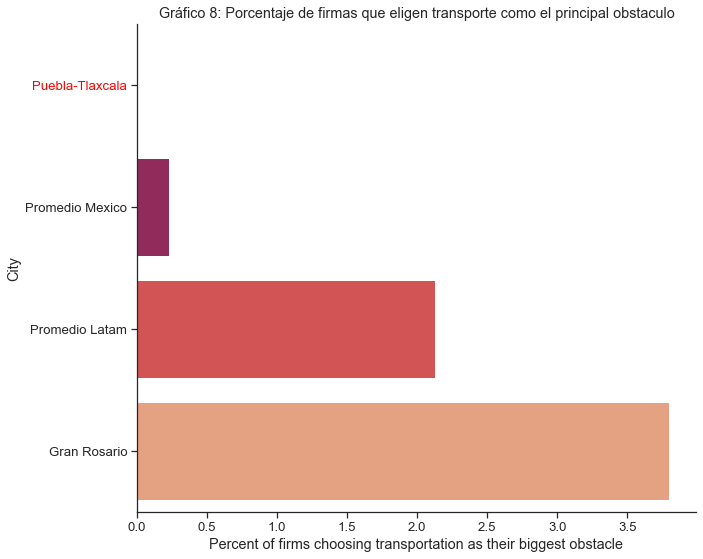

In [313]:
if city in es.index:    
    
    #Tabla
    plot = es.loc[:,'Percent of firms choosing transportation as their biggest obstacle'].to_frame()

    means = plot.mean().to_frame().T.append(plot.loc[city[0]].mean().to_frame().T).rename(columns={0:'Percent of firms choosing transportation as their biggest obstacle'})
    means['City'] = ['Promedio Latam','Promedio {}'.format(city[0])]
    means['Country'] = ['Promedio Latam','Promedio {}'.format(city[0])]
    means = means.set_index(['Country','City'])

    plot = plot.append(means)

    plotloc = plot.loc[idx[:,ref_prom],:].sort_values('Percent of firms choosing transportation as their biggest obstacle').droplevel(0).reset_index()

    #plot
    contgraf = contgraf + 1

    fig, ax = plt.subplots(figsize=(10,8))
    sns.barplot(x='Percent of firms choosing transportation as their biggest obstacle', y='City', data=plotloc , palette='rocket' , orient='h' )

    ax.set_title('Gráfico {}: Porcentaje de firmas que eligen transporte como el principal obstaculo'.format(contgraf))
    sns.set(font_scale=1.2)
    sns.set_style("ticks")
    sns.despine()
    plt.tight_layout()
    a = ax.get_yticklabels()
    a[[a[e].get_text() for e in range(len(a))].index(city[1])].set_color('red')

    plt.savefig("informe/images/big_obs_trans.png",bbox_inches='tight')

### Trabajo y Conocimiento

Firmas que creen que la educación de la fuerza laboral es el principal problema

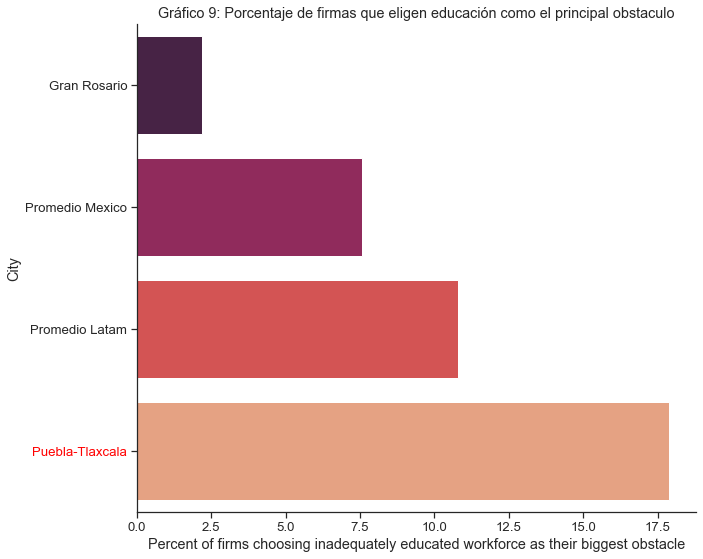

In [319]:
if city in es.index:

    #Tabla
    plot = es.loc[:,'Percent of firms choosing inadequately educated workforce as their biggest obstacle'].to_frame()

    means = plot.mean().to_frame().T.append(plot.loc[city[0]].mean().to_frame().T).rename(columns={0:'Percent of firms choosing inadequately educated workforce as their biggest obstacle'})
    means['City'] = ['Promedio Latam','Promedio {}'.format(city[0])]
    means['Country'] = ['Promedio Latam','Promedio {}'.format(city[0])]
    means = means.set_index(['Country','City'])

    plot = plot.append(means)

    plotloc = plot.loc[idx[:,ref_prom],:].sort_values('Percent of firms choosing inadequately educated workforce as their biggest obstacle').droplevel(0).reset_index()

    #plot
    contgraf = contgraf + 1

    fig, ax = plt.subplots(figsize=(10,8))
    sns.barplot(x='Percent of firms choosing inadequately educated workforce as their biggest obstacle', y='City', data=plotloc , palette='rocket' , orient='h' )

    ax.set_title('Gráfico {}: Porcentaje de firmas que eligen educación como el principal obstaculo'.format(contgraf))
    sns.set(font_scale=1.2)
    sns.set_style("ticks")
    sns.despine()
    plt.tight_layout()
    a = ax.get_yticklabels()
    a[[a[e].get_text() for e in range(len(a))].index(city[1])].set_color('red')

    plt.savefig("informe/images/big_obs_edu.png",bbox_inches='tight')

Laboral

In [17]:
if city in laboral.index:
    
    medias = laboral.reset_index().loc[laboral.reset_index()['City'].str.contains('Promedio')].mean().to_frame().T
    [medias['Country'],medias['City']] = ['Promedio Latam','Promedio Latam']
    medias = medias.set_index(['Country','City']).append(laboral.loc[idx[:,'Promedio {}'.format(city[0])],:])

    laboral_ref = laboral.append(medias).loc[idx[:,ref_prom],:].droplevel(0)

Act

In [363]:
if city[1] in laboral_ref.index:

    #Tabla
    act = laboral_ref[laboral_ref.columns[4:7]]
    act['dif'] = act['Tasa de Actividad Hombres'] - act['Tasa de Actividad Mujeres ']
    act = act.sort_values('Tasa de Actividad Total')
    act['Tasa de Actividad (total)'] = act['Tasa de Actividad Total'] * (-1)
    act = act.astype('float')

    #Plot
    contgraf = contgraf + 1

    #Creo limites del eje, valores para los ticks y labels
    x_range = ((5*round(act['Tasa de Actividad (total)'].min()/5))-5,(5*round(act['dif'].max()/5))+5)
    tickvals = [e for e in range(x_range[0],x_range[1]+5,5)]
    ticktext = [abs(e) for e in range(x_range[0],x_range[1]+5,5)]

    layout = go.Layout(yaxis=go.layout.YAxis(title='Ciudad'),
                       xaxis=go.layout.XAxis(
                           range=x_range,
                           tickvals=tickvals,
                           ticktext=ticktext,
                           title='Porcentaje de personas'),
                        barmode='overlay',
                        bargap=0.1,
                        template="simple_white",
                       title='Gráfico {}: Tasa de actividad y diferencia entre Hombres vs mujeres'.format(contgraf)
                      )

    data = [go.Bar(y=act.index,
                   x=act['dif'],
                   orientation='h',
                   name='Direferencia entre tasa de actividad (Hombres - Mujeres)',
                   text=np.round(act['dif'].to_numpy(),2),
                   hoverinfo='text',
                   marker=dict(color=colors[4]),
                        #hoverlabel=dict(hover_data={act['dif']:':.2f'})
                   ),
            go.Bar(y=act.index,
                   x=act['Tasa de Actividad (total)'],
                   orientation='h',
                   name='Tasa de actividad total',
                   text= np.round(act['Tasa de Actividad (total)'].to_numpy() * -1,2),
                   hoverinfo='text',
                   marker=dict(color=colors[8])
                   )]


    fig = go.Figure(data=data,layout=layout)

    fig.write_html(file="informe/images/actividad.html",full_html=False,include_plotlyjs='cdn')

Info y desempleo

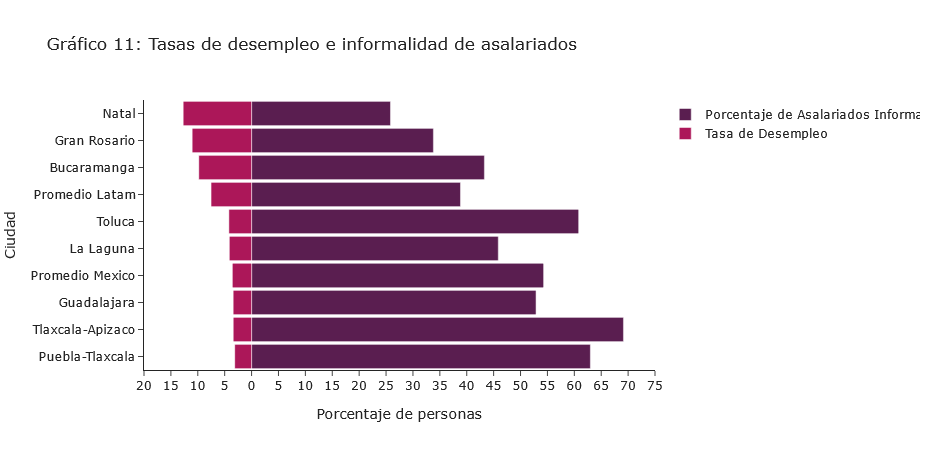

In [29]:
if city[1] in laboral_ref.index:

    #Tabla
    des = pd.concat([laboral_ref[laboral_ref.columns[1]],laboral_ref[laboral_ref.columns[7]]],axis=1)
    des = des.astype('float')
    des = des.sort_values('Tasa de Desempleo Total')
    des['Tasa de Desempleo (Total)'] = des['Tasa de Desempleo Total'] * (-1)

    #plot
    contgraf = contgraf + 1

    x_range = ((5*round(des['Tasa de Desempleo (Total)'].min()/5))-5,(5*round(des['% Asalariados Informales Total'].max()/5))+5)
    tickvals = [e for e in range(x_range[0],x_range[1]+5,5)]
    ticktext = [abs(e) for e in range(x_range[0],x_range[1]+5,5)]

    layout = go.Layout(yaxis=go.layout.YAxis(title='Ciudad'),
                       xaxis=go.layout.XAxis(
                           range=x_range,
                           tickvals=tickvals,
                           ticktext=ticktext,
                           title='Porcentaje de personas'),
                        barmode='overlay',
                        bargap=0.1,
                        template="simple_white",
                       title='Gráfico {}: Tasas de desempleo e informalidad de asalariados'.format(contgraf)
                      )

    data = [go.Bar(y=des.index,
                   x=des['% Asalariados Informales Total'],
                   orientation='h',
                   name='Porcentaje de Asalariados Informales',
                   text=np.round(des['% Asalariados Informales Total'].to_numpy(),2),
                   hoverinfo='text',
                   marker=dict(color=colors[4]),
                        #hoverlabel=dict(hover_data={act['dif']:':.2f'})
                   ),
            go.Bar(y=des.index,
                   x=des['Tasa de Desempleo (Total)'],
                   orientation='h',
                   name='Tasa de Desempleo',
                   text= np.round(des['Tasa de Desempleo (Total)'].to_numpy() * -1,2),
                   hoverinfo='text',
                   marker=dict(color=colors[8])
                   )]


    fig = go.Figure(
                    data=data,
                    layout=layout
    )

    fig.write_html(file="informe/images/desempleo.html",full_html=False,include_plotlyjs='cdn')

desempleo etario

In [38]:
if city[1] in laboral_ref.index:

    #Tabla
    deset = laboral_ref.loc[:,['Tasa de Desempleo 15-24','Tasa de Desempleo 25-54','Tasa de Desempleo 55 (+)']].sort_values('Tasa de Desempleo 25-54')
    des_plot = deset.stack().to_frame().reset_index().rename(columns={'level_1':'Rango Etario',0:'Porcentaje'}).set_index(['City'])

    fig, ax = plt.subplots(figsize=(16,10))

    contgraf = contgraf + 1
    g = sns.barplot(x=des_plot.index, y='Porcentaje', hue='Rango Etario', data=des_plot , palette='rocket' , linewidth=1)

    g.set_title('Gráfico {}: Tasas de desempleo según rango etario'.format(contgraf))
    g.set_xticklabels(des_plot.index.unique().tolist() , rotation=45 , ha='right')

    sns.set(font_scale=1.2)
    sns.set_style("ticks")
    sns.despine()
    a = ax.get_xticklabels()
    a[[a[e].get_text() for e in range(len(a))].index(city[1])].set_color('red')

    plt.tight_layout()
    plt.savefig("informe/images/des_etario.png",bbox_inches='tight')

Educación

In [44]:
if city[1] in laboral_ref.index:

    #Tabla
    edu = laboral_ref.loc[:,['% población con secundario completo Total','% población con superior completo Total']]
    edu = edu.astype('float')
    edu = edu.sort_values('% población con secundario completo Total')
    edu['% población con secundario completo (total)'] = edu['% población con secundario completo Total'] * (-1)

    #plot
    contgraf = contgraf + 1

    x_range = ((5*round(edu['% población con secundario completo (total)'].min()/5))-5,(5*round(edu['% población con superior completo Total'].max()/5))+5)
    tickvals = [e for e in range(x_range[0],x_range[1]+5,5)]
    ticktext = [abs(e) for e in range(x_range[0],x_range[1]+5,5)]

    layout = go.Layout(yaxis=go.layout.YAxis(title='Ciudad'),
                       xaxis=go.layout.XAxis(
                           range=x_range,
                           tickvals=tickvals,
                           ticktext=ticktext,
                           title='Porcentaje de personas'),
                        barmode='overlay',
                        bargap=0.1,
                        template="simple_white",
                       title='Gráfico {}: Porcentaje de población con secundario y superior completo'.format(contgraf)
                      )

    data = [go.Bar(y=edu.index,
                   x=edu['% población con superior completo Total'],
                   orientation='h',
                   name='Porcentaje de población con superior completo',
                   text=np.round(edu['% población con superior completo Total'].to_numpy(),2),
                   hoverinfo='text',
                   marker=dict(color=colors[4]),
                        #hoverlabel=dict(hover_data={act['dif']:':.2f'})
                   ),
            go.Bar(y=edu.index,
                   x=edu['% población con secundario completo (total)'],
                   orientation='h',
                   name='Porcentaje de población con secundario completo',
                   text= np.round(edu['% población con secundario completo (total)'].to_numpy() * -1,2),
                   hoverinfo='text',
                   marker=dict(color=colors[8])
                   )]

    fig = go.Figure(data=data,
                    layout=layout)

    fig.write_html(file="informe/images/edu1.html",full_html=False,include_plotlyjs='cdn')

In [46]:
if city[1] in laboral_ref.index:

    #Tabla
    edu2 = laboral_ref.loc[:,['% población con superior completo 25 a 35 años de edad','% población con secundario completo % población 18-25 años  que se encuentra estudiando nivel superior o terciario']].sort_values('% población con superior completo 25 a 35 años de edad')
    edu2 = edu2.rename(columns={'% población con superior completo 25 a 35 años de edad':'25-35 años con superior completo','% población con secundario completo % población 18-25 años  que se encuentra estudiando nivel superior o terciario':'18-25 años estudiando terciario/superior'})
    edu_plot2 = edu2.stack().to_frame().reset_index().rename(columns={'level_1':'Grupo',0:'Porcentaje'}).set_index(['City'])

    #Plot
    fig, ax = plt.subplots(figsize=(16,10))

    contgraf = contgraf + 1
    g = sns.barplot(x=edu_plot2.index, y='Porcentaje', hue='Grupo', data=edu_plot2 , palette='rocket' , linewidth=1)

    g.set_title('Gráfico {}: Educación superior'.format(contgraf))
    g.set_xticklabels(edu_plot2.index.unique().tolist() , rotation=45 , ha='right')

    sns.set(font_scale=1.2)
    sns.set_style("ticks")
    sns.despine()
    plt.tight_layout()
    a = ax.get_xticklabels()
    a[[a[e].get_text() for e in range(len(a))].index(city[1])].set_color('red')

    plt.savefig("informe/images/edu2.png",bbox_inches='tight')

### Conglomerados y Cadenas de Valor

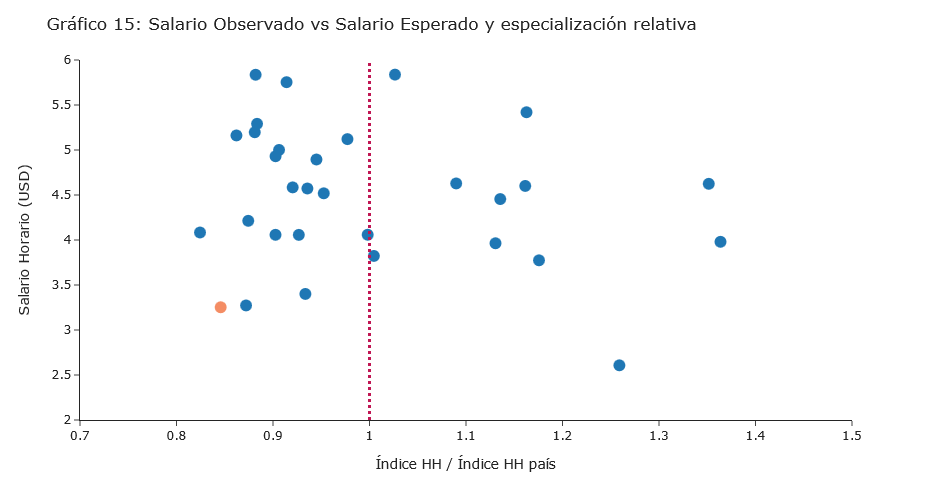

In [116]:
if city in laboral.index:

    #Tabla
    hh = laboral.loc[city[0],'Salario Horario (PPP 2011)'].to_frame().drop(
        index='Promedio {}'.format(city[0])).join(
        sectores.loc[:,['Salario Estimado','HHc/HHp']]).reset_index().rename(
        columns={'HHc/HHp':'Índice HH / Índice HH país','Salario Horario (PPP 2011)':'Salario Horario (USD)'}).drop(
        columns='Country')

    hh1 = hh.drop(index=hh[hh['City']==city[1]].index)
    hh2 = hh[hh['City']==city[1]]

    #Plot

    fig = px.scatter(hh1, x="Índice HH / Índice HH país", y="Salario Horario (USD)",
                     hover_data=["City","Índice HH / Índice HH país","Salario Horario (USD)"],
                     template='simple_white',
                     #color = color[2],
                     #marker=dict( color=colors[3], size=12),
                     width=750,
                     height=500
                    )

    #Guardo los valores de la ciudad principal en una lista para el "hover"
    hov = hh2.loc[:,["City","Índice HH / Índice HH país", "Salario Horario (USD)"]].values.tolist()[0]

    #Gráfico

    contgraf = contgraf + 1

    fig.add_trace(go.Scatter( 
                    mode='markers', 
                    x=hh2['Índice HH / Índice HH país'], 
                    y=hh2['Salario Horario (USD)'],
                    marker=dict( color=colors[15], size=12),
                    showlegend=False,
                    text='City: {0}<br />Índice HH / Índice HH país: {1}<br />Salario Horario (USD): {2}'.format(hov[0], hov[1], hov[2]),
                    hoverinfo='text'
                            )
                 )

    fig.update_traces(marker=dict(size=12),
                      selector=dict(mode='markers')
                     )

    #Rangos de ejes
    x_range = (round(hh['Índice HH / Índice HH país'].min()-0.1,1),round(hh['Índice HH / Índice HH país'].max()+0.1,1))
    y_range = (round(hh['Salario Horario (USD)'].min()-0.5),round(hh['Salario Horario (USD)'].max()+0.5))

    fig.update_layout(xaxis_range=[x_range[0],x_range[1]],
                      yaxis_range=[y_range[0],y_range[1]],
                      title='Gráfico {}: Salario Observado vs Salario Esperado y especialización relativa'.format(contgraf)
                     )

    # add a "target" line
    fig.add_shape(
        type="line", line_color=colors[9], line_width=3, opacity=1, line_dash="dot",
        x0=1, x1=1, xref="x", y0=0, y1=12, yref="y"
    )

    fig.write_html(file="informe/images/hh_salario.html",full_html=False,include_plotlyjs='cdn')

# Distribución de masa salarial, empleo y salarios

Empleo y Masa Salarial

In [180]:
if city in sectores.index:

    #Empleos
    e = sectores.iloc[:,10:20]

    emedias = e.mean().to_frame().T.append(e.loc[city[0]].mean().to_frame().T)
    emedias['City'] = ['Promedio Latam','Promedio {}'.format(city[0])]
    emedias['Country'] = ['Promedio Latam','Promedio {}'.format(city[0])]

    e = e.append(emedias.set_index(['Country','City']))

    eplot = e.loc[idx[:,ref_prom],:]
    eplot = eplot.rename(columns=dict(zip(eplot.columns.tolist(),[sectores.columns[31:41].tolist()[e] for e in range(10)])))

    eplot['df']='Empleo'

    a = eplot.loc[idx[:,[city[1],'Promedio {}'.format(city[0]),'Promedio Latam']],:]

    eplot = a.append(
                eplot.loc[
                    eplot.index.difference(a.index)])

    eplot = eplot.droplevel(0)

    #Masas Salariales
    ms = sectores.iloc[:,31:41]

    msmedias = ms.mean().to_frame().T.append(ms.loc[city[0]].mean().to_frame().T)
    msmedias['City'] = ['Promedio Latam','Promedio {}'.format(city[0])]
    msmedias['Country'] = ['Promedio Latam','Promedio {}'.format(city[0])]

    ms = ms.append(msmedias.set_index(['Country','City']))

    msplot = ms.loc[idx[:,ref_prom],:]
    msplot['df']='Masa Salarial'

    a = msplot.loc[idx[:,[city[1],'Promedio {}'.format(city[0]),'Promedio Latam']],:]

    msplot = a.append(
                msplot.loc[
                    msplot.index.difference(a.index)])

    msplot = msplot.droplevel(0)

    #Concateno ambas bases

    df = pd.concat([pd.melt(eplot.reset_index().rename(columns={'index':'City'}),id_vars=['df','City']),pd.melt(msplot.reset_index().rename(columns={'index':'City'}),id_vars=['df','City'])],ignore_index=True)
    df = df.set_index(['df','City','variable'])
    df["vcs"] = df.groupby(level=["df","City"]).cumsum()
    df = df.reset_index()
    df = df.replace({'Promedio Latam':'P. Latam','Promedio {}'.format(city[0]):'P. {}'.format(city[0])})

    colors2 = [colors[e] for e in range(0,20,2)]

    #Plot
    fig = go.Figure()

    contgraf = contgraf + 1

    fig.update_layout(
        template="simple_white",
        xaxis=dict(title_text="Ciudad",tickfont_size=10),
        yaxis=dict(title_text="Actividades como % del total"),
        barmode="stack",
        title_text='Gráfico {}: Comparaciones entre empleo y masa salarial por sector'.format(contgraf)
    )


    for r, c in zip(df.variable.unique(), colors2):
        plot_df = df[df.variable == r]
        fig.add_trace(
            go.Bar(x=[plot_df.City, plot_df.df], y=plot_df.value, name=r, marker_color=c),
        )

    fig.update_layout() 
    fig.write_html("informe/images/empleoymasasalarial.html",full_html=False,include_plotlyjs='cdn')

Salarios

In [204]:
if city in sectores.index:

    #Tablas
    salarios = sectores.loc[:,['wages_ s{}'.format(e) for e in range(1,11)]]

    salariosm = salarios.mean().to_frame().T.append(salarios.loc[city[0]].mean().to_frame().T)
    salariosm['City'] = ['Promedio {}'.format(city[0]),'Promedio Latam']
    salariosm['Country'] = ['Promedio {}'.format(city[0]),'Promedio Latam']
    salariosm = salariosm.set_index(['Country','City'])

    salarios = salarios.append(salariosm)
    salarios = salarios.loc[idx[:,ref_prom],:]
    salarios = salarios.droplevel(0)

    salarios['color'] = colors[10]
    salarios.at[city[1],'color'] = colors[1]

    #Melt
    mydict=dict(zip(salarios.columns.tolist()[:-1],sectores.iloc[:5,31:41].columns.tolist()))

    plot = pd.melt(salarios.reset_index().rename(columns=mydict),id_vars=['City','color']).rename(columns={'variable':'Actividad','value':'Salario'})

    df_dict={}

    for v in plot['Actividad'].unique():
        df_dict[v] = plot[plot['Actividad']==v].sort_values('Salario')

    #plot1
    contgraf = contgraf + 1

    fig = go.Figure(data=[go.Bar( x=df_dict[list(df_dict.keys())[0]]['City'], y=df_dict[list(df_dict.keys())[0]]['Salario'] , marker={'color': df_dict[list(df_dict.keys())[0]]['color']})
                         ])

    updatemenus = [{'buttons': [
                {
                    'method': 'update',
                    'label': list(df_dict.keys())[0],
                    'args': [
                        {'y': [df_dict[list(df_dict.keys())[0]]['Salario']],
                         'x': [df_dict[list(df_dict.keys())[0]]['City']],
                         'marker':[{'color': df_dict[list(df_dict.keys())[0]]['color']}]
                        }]
                },
                {
                    'method': 'update',
                    'label': list(df_dict.keys())[1],
                    'args': [
                        {'y': [df_dict[list(df_dict.keys())[1]]['Salario']],
                         'x': [df_dict[list(df_dict.keys())[1]]['City']],
                         'marker':[{'color': df_dict[list(df_dict.keys())[1]]['color']}]
                        }]
                },
                {
                    'method': 'update',
                    'label': list(df_dict.keys())[2],
                    'args': [
                        {'y': [df_dict[list(df_dict.keys())[2]]['Salario']],
                         'x': [df_dict[list(df_dict.keys())[2]]['City']],
                         'marker':[{'color': df_dict[list(df_dict.keys())[2]]['color']}]
                        }]
                },
                {
                    'method': 'update',
                    'label': list(df_dict.keys())[3],
                    'args': [
                        {'y': [df_dict[list(df_dict.keys())[3]]['Salario']],
                         'x': [df_dict[list(df_dict.keys())[3]]['City']],
                         'marker':[{'color': df_dict[list(df_dict.keys())[3]]['color']}]
                        }]
                },
                {
                    'method': 'update',
                    'label': list(df_dict.keys())[4],
                    'args': [
                        {'y': [df_dict[list(df_dict.keys())[4]]['Salario']],
                         'x': [df_dict[list(df_dict.keys())[4]]['City']],
                         'marker':[{'color': df_dict[list(df_dict.keys())[4]]['color']}]
                        }]
                },
                {
                    'method': 'update',
                    'label': list(df_dict.keys())[5],
                    'args': [
                        {'y': [df_dict[list(df_dict.keys())[5]]['Salario']],
                         'x': [df_dict[list(df_dict.keys())[5]]['City']],
                         'marker':[{'color': df_dict[list(df_dict.keys())[5]]['color']}]
                        }]
                },
                {
                    'method': 'update',
                    'label': list(df_dict.keys())[6],
                    'args': [
                        {'y': [df_dict[list(df_dict.keys())[6]]['Salario']],
                         'x': [df_dict[list(df_dict.keys())[6]]['City']],
                         'marker':[{'color': df_dict[list(df_dict.keys())[6]]['color']}]
                        }]
                },
                {
                    'method': 'update',
                    'label': list(df_dict.keys())[7],
                    'args': [
                        {'y': [df_dict[list(df_dict.keys())[7]]['Salario']],
                         'x': [df_dict[list(df_dict.keys())[7]]['City']],
                         'marker':[{'color': df_dict[list(df_dict.keys())[7]]['color']}]
                        }]
                },
                {
                    'method': 'update',
                    'label': list(df_dict.keys())[8],
                    'args': [
                        {'y': [df_dict[list(df_dict.keys())[8]]['Salario']],
                         'x': [df_dict[list(df_dict.keys())[8]]['City']],
                         'marker':[{'color': df_dict[list(df_dict.keys())[8]]['color']}]
                        }]
                },
                {
                    'method': 'update',
                    'label': list(df_dict.keys())[9],
                    'args': [
                        {'y': [df_dict[list(df_dict.keys())[9]]['Salario']],
                         'x': [df_dict[list(df_dict.keys())[9]]['City']],
                         'marker':[{'color': df_dict[list(df_dict.keys())[9]]['color']}]
                        }               
                    ]
                }

            ],
            'direction': 'down',
            'showactive': True,
        }
    ]

    fig.update_layout(template="simple_white" , updatemenus=updatemenus , title_text='Gráfico {}.B: Comparativo Salarios por actividad'.format(contgraf) , xaxis={'tickangle':-45})
    fig.update_traces(marker_line_width=1.5, opacity=0.6)

    fig.write_html("informe/images/wages.html",full_html=False,include_plotlyjs='cdn')

    #plot2

    fig, ax = plt.subplots(1,1,figsize=(24,12))

    sns.barplot(x='City', y='Salario', hue='Actividad', data=plot , ax = ax, palette='rocket').set_title(
        'Gráfico {}.A: Salarios Horarios promedio según actividad (USD)'.format(contgraf))

    ax.set_xticklabels(plot['City'].unique().tolist() , rotation=45 , ha='right')
    a = ax.get_xticklabels()
    a[[a[e].get_text() for e in range(len(a))].index(city[1])].set_color('red')

    sns.set(font_scale=1.2)
    sns.set_style("ticks")
    sns.despine()
    plt.tight_layout()

    plt.savefig("informe/images/salarios.png",bbox_inches='tight')

### Facilitación de Negocios

Doing BIZ

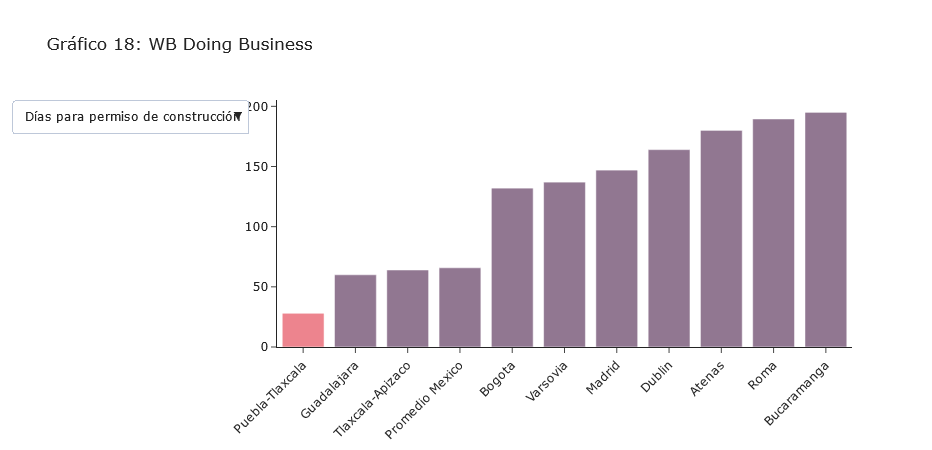

In [241]:
if city in db.index:
    
    #Tabla
    ref_db = ref + ['Promedio {}'.format(city[0]),'Varsovia','Madrid','Roma','Dublin','Atenas','Bogota']

    dbiz = db[db.columns[db.columns.str.contains('Días')].tolist()]

    means = dbiz.loc[['{}'.format(city[0])]].mean().to_frame().T
    means['City'] = 'Promedio {}'.format(city[0])
    means['Country'] = 'Promedio {}'.format(city[0])
    means = means.reset_index().set_index(['Country','City'])

    db_plot = dbiz.append(means).loc[idx[:,ref_db],:]

    dp = pd.melt(
        db_plot.reset_index(),id_vars=['City'], 
        value_vars=['Días permiso de construcción','Días registro de propiedad','Días comienzo de negocio'])

    dp['color'] = colors[3]
    dp.loc[dp['City']==city[1],'color'] = colors[11]

    df1=dp[dp['variable']=='Días permiso de construcción'].sort_values('value').dropna()
    df2=dp[dp['variable']=='Días registro de propiedad'].sort_values('value').dropna()
    df3=dp[dp['variable']=='Días comienzo de negocio'].sort_values('value').dropna()

    #Plot

    fig = go.Figure(data=[go.Bar( x=df1['City'], y=df1['value'] , marker={'color': df1['color']})
                         ])
    #contgraf = contgraf + 1

    updatemenus = [
        {
            'buttons': [
                {
                    'method': 'update',
                    'label': 'Días para permiso de construcción',
                    'args': [
                        {'y': [df1['value']],
                         'x': [df1['City']],
                         'marker':[{'color': df1['color']}]
                        },  
                    ]
                },
                {
                    'method': 'update',
                    'label': 'Días para registro de propiedad',
                    'args': [
                        {'y': [df2['value']],
                         'x': [df2['City']],
                         'marker':[{'color': df2['color']}]
                        },
                    ]
                },
                {
                    'method': 'update',
                    'label': 'Días para comienzo de negocio',
                    'args': [
                        {'y': [df3['value']],
                         'x': [df3['City']],
                         'marker':[{'color': df3['color']}]
                        },
                    ]
                }
            ],
            'direction': 'down',
            'showactive': True,
        }
    ]

    fig.update_layout(template="simple_white" , updatemenus=updatemenus , title_text='Gráfico {}: WB Doing Business'.format(contgraf) , xaxis={'tickangle':-45})
    fig.update_traces(marker_line_width=1.5, opacity=0.6)
    fig.write_html("informe/images/db.html",full_html=False,include_plotlyjs='cdn')

ES días

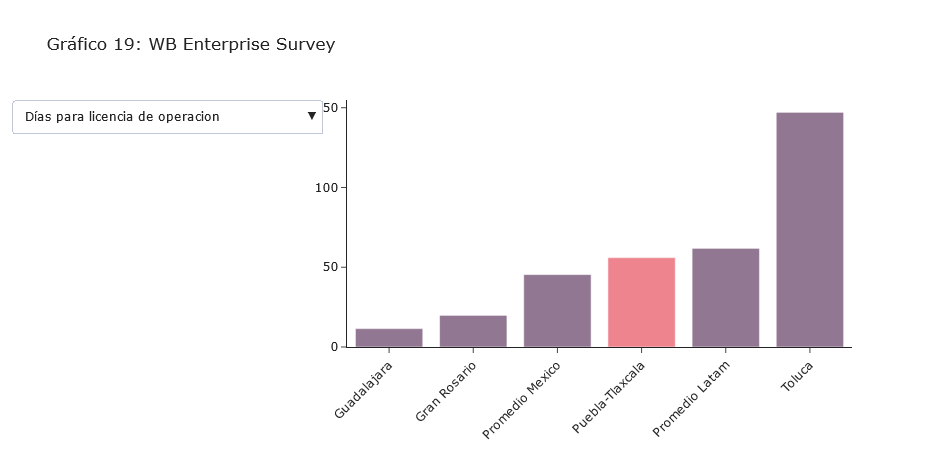

In [249]:
if city in es2.index:
    
    #Tabla

    es_dias = es2[es2.columns[es2.columns.str.contains('Días')].tolist()]

    means = es_dias.loc[city[0]].mean().to_frame().T.append(
                                                                es_dias.mean().to_frame().T)
    means['City'] = ['Promedio {}'.format(city[0]),'Promedio Latam']
    means['Country'] = ['Promedio {}'.format(city[0]),'Promedio Latam']
    means = means.set_index(['Country','City'])

    esd_plot = es_dias.append(means).loc[idx[:,ref_prom],:]

    esd = pd.melt(
        esd_plot.reset_index(),id_vars=['City'], 
        value_vars=es_dias.columns)

    esd['color'] = colors[3]
    esd.loc[esd['City']==city[1],'color'] = colors[11]

    df1=esd[esd['variable']=='Días para Lic. de operación'].sort_values('value').dropna()
    df2=esd[esd['variable']=='Días para Permiso relacionado con construción'].sort_values('value').dropna()
    df3=esd[esd['variable']=='Días para Licencia de importación'].sort_values('value').dropna()

    #Plot

    fig = go.Figure(data=[go.Bar( x=df1['City'], y=df1['value'] , marker={'color': df1['color']})
                         ])
    contgraf = contgraf + 1

    updatemenus = [
        {
            'buttons': [
                {
                    'method': 'update',
                    'label': 'Días para licencia de operacion',
                    'args': [
                        {'y': [df1['value']],
                         'x': [df1['City']],
                         'marker':[{'color': df1['color']}]
                        },  
                    ]
                },
                {
                    'method': 'update',
                    'label': 'Días para permiso relacionado a la construcción',
                    'args': [
                        {'y': [df2['value']],
                         'x': [df2['City']],
                         'marker':[{'color': df2['color']}]
                        },
                    ]
                },
                {
                    'method': 'update',
                    'label': 'Días para Licencia de importación',
                    'args': [
                        {'y': [df3['value']],
                         'x': [df3['City']],
                         'marker':[{'color': df3['color']}]
                        },
                    ]
                }
            ],
            'direction': 'down',
            'showactive': True,
        }
    ]

    fig.update_layout(template="simple_white" , updatemenus=updatemenus , title_text='Gráfico {}: WB Enterprise Survey'.format(contgraf) , xaxis={'tickangle':-45})
    fig.update_traces(marker_line_width=1.5, opacity=0.6)
    fig.write_html("informe/images/es_dias.html",full_html=False,include_plotlyjs='cdn')

3 Biggest obstacles

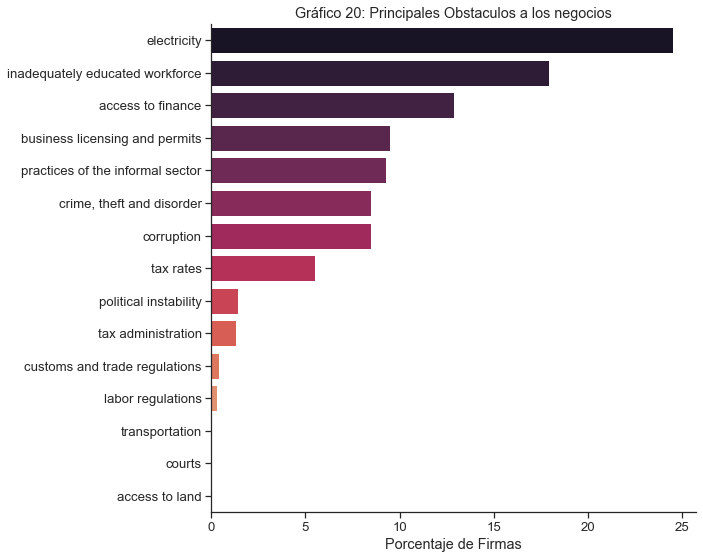

In [253]:
if city in es.index:
    
    cols = es.columns[1:-3].str.replace('Percent of firms choosing ','').str.replace(' as their biggest obstacle','')
    mydict = dict(zip(es.columns[1:-3].tolist(),cols))
    es = es.rename(columns=mydict)

    bobs = es.drop(
        columns=['City old','City2','_merge','Year']).loc[
        city].sort_values(
        ascending=False).to_frame().T.T.droplevel(0, axis=1).rename(
        columns={city[1]:'Porcentaje de Firmas'})

    #Plot
    contgraf = contgraf + 1
    
    fig, ax = plt.subplots(figsize=(10,8)) 
    sns.barplot(x='Porcentaje de Firmas', y=bobs.index, data=bobs , palette='rocket' , orient='h' ).set_title(
        'Gráfico {}: Principales Obstaculos a los negocios'.format(contgraf))

    sns.set(font_scale=1.2)
    sns.set_style("ticks")
    sns.despine()
    plt.tight_layout()

    plt.savefig("informe/images/biggest_obs.png",bbox_inches='tight')

Homicidios

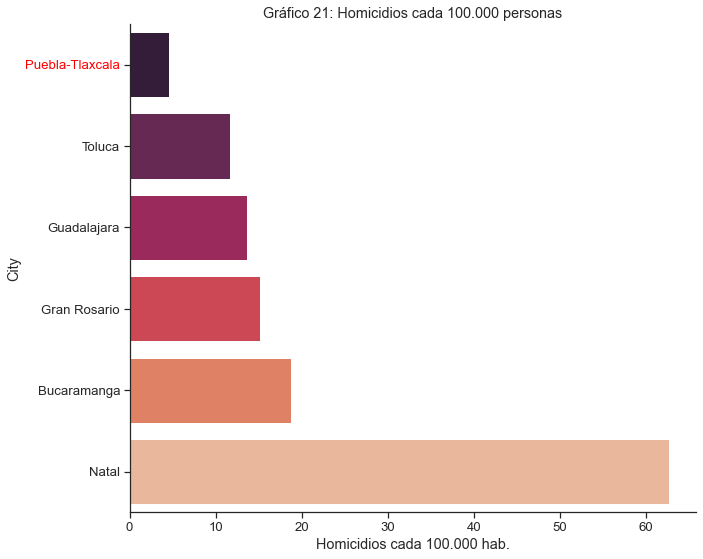

In [269]:
if city in hom.index:
    homicidios_ref = hom.loc[idx[:,ref],:].droplevel(0).sort_values('Homicidios cada 100.000 hab.')

    fig, ax = plt.subplots(figsize=(10,8))
    
    contgraf = contgraf + 1
    sns.barplot(x='Homicidios cada 100.000 hab.', y=homicidios_ref.index, data=homicidios_ref , palette='rocket' , orient='h' ).set_title(
        'Gráfico {}: Homicidios cada 100.000 personas'.format(contgraf))

    a = ax.get_yticklabels()
    a[[a[e].get_text() for e in range(len(a))].index(city[1])].set_color('red')
    
    sns.set(font_scale=1.2)
    sns.set_style("ticks")
    sns.despine()
    plt.tight_layout()

    plt.savefig("informe/images/homicidios.png",bbox_inches='tight')

Properati

In [285]:
if city in prope_com.index:

    refp = ref + ['Promedio Argentina','Promedio Colombia','Promedio Ecuador','Promedio Peru','Promedio Uruguay','Promedio Latam']

    medias = prope_com.groupby(['Country','property_type']).mean()
    ml =  medias.index.get_level_values(0).tolist()
    medias['City'] = ['Promedio ' + e for e in ml]
    medias = medias.reset_index().set_index(['Country','City'])

    pcom = prope_com.append(medias)

    df = pcom.loc[idx[:,refp],['property_type','Precio x m2']].droplevel(0).reset_index()
    df['color'] = colors[3]
    df.loc[df['City']==city[1],'color'] = colors[11]

    df1=df[df['property_type']=='Depósito'].sort_values('Precio x m2').dropna()
    df2=df[df['property_type']=='Local comercial'].sort_values('Precio x m2').dropna()
    df3=df[df['property_type']=='Oficina'].sort_values('Precio x m2').dropna()

    #Plot
    #contgraf = contgraf + 1

    fig = go.Figure(data=[go.Bar( x=df1['City'], y=df1['Precio x m2'] , marker={'color': df1['color']})
                         ])

    updatemenus = [
        {
            'buttons': [
                {
                    'method': 'update',
                    'label': 'Precio Promedio Depósito',
                    'args': [
                        {'y': [df1['Precio x m2']],
                         'x': [df1['City']],
                         'marker':[{'color': df1['color']}]
                        },  
                    ]
                },
                {
                    'method': 'update',
                    'label': 'Precio Promedio Local comercial',
                    'args': [
                        {'y': [df2['Precio x m2']],
                         'x': [df2['City']],
                         'marker':[{'color': df2['color']}]
                        },
                    ]
                },
                {
                    'method': 'update',
                    'label': 'Precio Promedio Oficina',
                    'args': [
                        {'y': [df3['Precio x m2']],
                         'x': [df3['City']],
                         'marker':[{'color': df3['color']}]
                        },
                    ]
                }
            ],
            'direction': 'down',
            'showactive': True,
        }
    ]

    fig.update_layout(template="simple_white" 
                      , updatemenus=updatemenus 
                      , title_text='Gráfico {}: Precios promedio de m2 de Propiedades Comerciales en USD'.format(contgraf)
                      , xaxis={'tickangle':-45})

    fig.update_traces(marker_line_width=1.5, opacity=0.6)

    fig.write_html("informe/images/prope.html",full_html=False,include_plotlyjs='cdn')

#### Sueldos x vivienda (promedio)

In [475]:
if city in prope_vi.index:
    
    #Tabla
    mcon = prope_vi['Cantidad de salarios mensuales para adquirir Propiedad 60m2'].to_frame().groupby('Country').mean()
    mcon['City'] = ['Promedio Argentina','Promedio Colombia','Promedio Ecuador','Promedio Peru','Promedio Uruguay']
    mcon = mcon.reset_index().set_index(['Country','City'])

    m = pd.DataFrame({'Country':['Latam'],
                      'City':['Promedio Latam'],
                      'Cantidad de salarios mensuales para adquirir Propiedad 60m2':
                          [prope_vi['Cantidad de salarios mensuales para adquirir Propiedad 60m2'].mean()]}).set_index(
        ['Country','City'])

    refp = ref + ['Promedio Argentina','Promedio Colombia','Promedio Ecuador','Promedio Peru','Promedio Uruguay','Promedio Latam']

    wagexcasa = prope_vi.append(m).append(mcon).loc[
        idx[:,refp],'Cantidad de salarios mensuales para adquirir Propiedad 60m2'].droplevel(0).to_frame().sort_values(
        'Cantidad de salarios mensuales para adquirir Propiedad 60m2')

    wagexcasa['color'] = colors[10]
    wagexcasa.at[city[1],'color'] = colors[1]
    wagexcasa = wagexcasa.reset_index()

    #Plot
    contgraf = contgraf + 1
    
    fig = go.Figure(data=[go.Bar(x=wagexcasa['City'], 
                                 y=wagexcasa['Cantidad de salarios mensuales para adquirir Propiedad 60m2'] , 
                                 marker={'color': wagexcasa['color']})])

    fig.update_layout(template="simple_white" 
                      , title_text='Gráfico {}: Cantidad de salarios mensuales para adquirir una propiedad promedio de 60 mts2'.format(contgraf)
                      , xaxis={'tickangle':-45})
    
    fig.update_traces(marker_line_width=1.5, opacity=0.6)

    fig.write_html("informe/images/vivienda.html",full_html=False,include_plotlyjs='cdn')

### Ver tema de ciudades de Colombia

In [90]:
wcol = laboral.loc['Colombia','Salario Horario (PPP 2011)'].to_frame().drop(index='Promedio Colombia').join(sectores.loc['Colombia',['Salario Observado','Salario Estimado']],how='left').reset_index()

In [87]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.005, point['y'], str(point['val']))

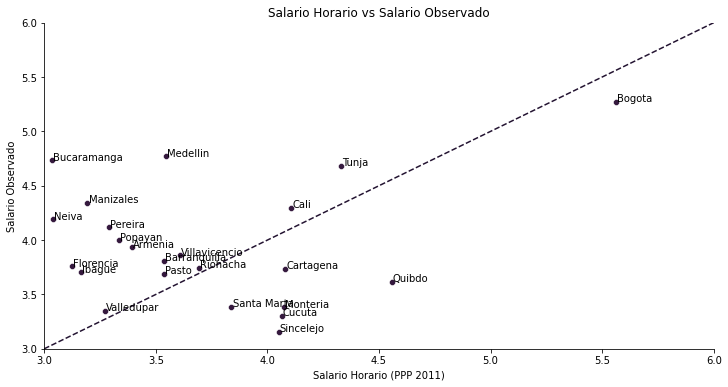

In [112]:
fig , ax = plt.subplots(figsize=(12,6))

#sns.scatterplot(data=wcol,x='Salario Horario (PPP 2011)',y='Salario Estimado',ax=ax1,palette='rocket').set_title('Salario Horario vs Salario Estimado')
sns.scatterplot(data=wcol,x='Salario Horario (PPP 2011)',y='Salario Observado',ax=ax,palette='rocket').set_title('Salario Horario vs Salario Observado')

#label_point( wcol['Salario Horario (PPP 2011)'] , wcol['Salario Estimado'] , wcol['City'] , ax1)
label_point( wcol['Salario Horario (PPP 2011)'] , wcol['Salario Observado'] , wcol['City'] , ax)

#ax1.set_xlim(3,6)
#ax1.set_ylim(3.5,4.5)

ax.set_xlim(3,6)
ax.set_ylim(3,6)

sns.despine()

#ax1.axline(xy1=(0,0),xy2=(6,6),linestyle='--',c=colors[1])
ax.axline(xy1=(0,0),xy2=(6,6),linestyle='--',c=colors[1])

plt.savefig("c:/users/franco/python/caf/comp_salarios.png",bbox_inches='tight')

In [117]:
wcol2 = wcol.loc[:,['City','Salario Horario (PPP 2011)','Salario Observado']].set_index('City')

In [119]:
wcol2['Diferencia S. Horario - S. Observado'] = wcol2['Salario Horario (PPP 2011)'] - wcol2['Salario Observado']

In [123]:
wcol2.sort_values('Diferencia S. Horario - S. Observado',ascending=False).to_excel("c:/users/franco/python/caf/comp_salarios.xlsx")

In [126]:
print(BeautifulSoup(wcol2.sort_values('Diferencia S. Horario - S. Observado',ascending=False).head().to_html(), 'html.parser'))

<table border="1" class="dataframe">
<thead>
<tr style="text-align: right;">
<th></th>
<th>Salario Horario (PPP 2011)</th>
<th>Salario Observado</th>
<th>Diferencia S. Horario - S. Observado</th>
</tr>
<tr>
<th>City</th>
<th></th>
<th></th>
<th></th>
</tr>
</thead>
<tbody>
<tr>
<th>Quibdo</th>
<td>4.56</td>
<td>3.62</td>
<td>0.94</td>
</tr>
<tr>
<th>Sincelejo</th>
<td>4.05</td>
<td>3.16</td>
<td>0.89</td>
</tr>
<tr>
<th>Cucuta</th>
<td>4.06</td>
<td>3.30</td>
<td>0.76</td>
</tr>
<tr>
<th>Monteria</th>
<td>4.07</td>
<td>3.38</td>
<td>0.69</td>
</tr>
<tr>
<th>Santa Marta</th>
<td>3.84</td>
<td>3.39</td>
<td>0.45</td>
</tr>
</tbody>
</table>


In [127]:
print(BeautifulSoup(wcol2.sort_values('Diferencia S. Horario - S. Observado').head().to_html(), 'html.parser'))

<table border="1" class="dataframe">
<thead>
<tr style="text-align: right;">
<th></th>
<th>Salario Horario (PPP 2011)</th>
<th>Salario Observado</th>
<th>Diferencia S. Horario - S. Observado</th>
</tr>
<tr>
<th>City</th>
<th></th>
<th></th>
<th></th>
</tr>
</thead>
<tbody>
<tr>
<th>Bucaramanga</th>
<td>3.04</td>
<td>4.74</td>
<td>-1.70</td>
</tr>
<tr>
<th>Medellin</th>
<td>3.55</td>
<td>4.77</td>
<td>-1.22</td>
</tr>
<tr>
<th>Neiva</th>
<td>3.04</td>
<td>4.19</td>
<td>-1.15</td>
</tr>
<tr>
<th>Manizales</th>
<td>3.19</td>
<td>4.34</td>
<td>-1.15</td>
</tr>
<tr>
<th>Pereira</th>
<td>3.29</td>
<td>4.12</td>
<td>-0.83</td>
</tr>
</tbody>
</table>
